# Example Data

---

---


### Overview

This notebook generates a fake dataset to use throughout the rest of the examples.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

### Generate data

The dataset consists of 4 features, and a target variable:
1. `x1` is a float with a range between -1 and 1, and a cubic relationship with `y`.  However, x values between 0.5 and 1 are absent, and the curvature is subtle to represent a use case where monotonicity is expected, where noise would otherwise create non-monotonicity.
1. `x2` is a binary variable that's almost perfectly correlated with `x1`, which could also enter the model monotonically.
1. `x3` is a categorical feature taking on of 50 possible integer values.  For each distinct value of `x3`, `x1` covers it's entire range and `y` has slightly varying levels and scaling of its underlying cubic shape.
1. `x4` is completely independent with `y`.  It represents a possible noisy non-monotonic feature.
1. `y` is the target float to be predicted and is a function of `x1`, `x2`, and `x3` with a small amount of random normal noise added.

In [2]:
df = []
for i in range(50):
    x1 = np.concatenate([np.linspace(-1, 0, num=20), np.linspace(0.5, 1, num=10)])
    y = -x1 - x1 ** 2 + 2 * x1 ** 3
    x2 = x1 > (0 - (np.random.rand(len(x1)) > 0.8))
    y += x2 * 0.2
    x3 = np.repeat(i, len(x1))
    y += (np.random.rand() / 3)
    y *= (1 + np.random.normal() / 10)
    y += np.random.normal(size=(len(x1))) / 10
    x4 = np.random.normal(size=len(x1))
    df.append(pd.DataFrame({'y': y.astype('float32'), 
                            'x1': x1.astype('float32'),
                            'x2': x2.astype('float32'),
                            'x3': x3.astype('int'), 
                            'x4': x4.astype('float32')}))
df = pd.concat(df, axis=0)

---

### Quick visualization

- Notice the cubic relationship between `x1` and `y`.
- `y` is not quite normally distributed, with a longer left tail.
- `x2`s relationship with `y` is definitely positive, but noise exists.
- `x4` is of course normally distributed and uncorrelated with `y`.

/home/djarpin/anaconda3/envs/pytorch/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


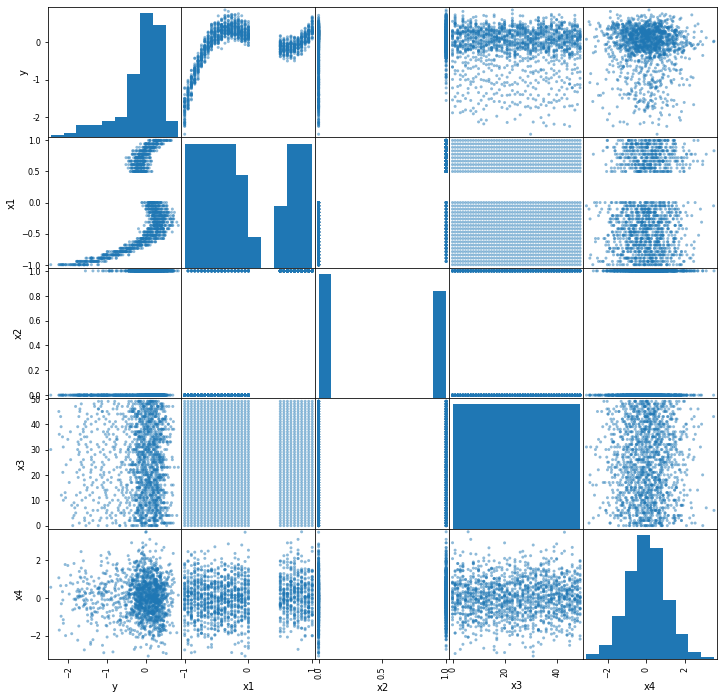

In [3]:
pd.plotting.scatter_matrix(df, figsize=(12, 12))
plt.show()

---

### Output

- Randomly generate a split of training and test data.  
  - Note, this dataset loosely resembles a stacked time-series dataset where each distinct value of `x3` represents a cross-sectional unit and `x1` represents time, in which case we would need to be more careful about splitting data to avoid information leakage.  However, since our example models won't specifically focus on time-series featurization, we'll stick with a simple 90-10 split.
- Output the datasets as pickles to be quickly read in later, and to preserve data types (important for using skorch).

In [4]:
split = np.random.uniform(size=len(df)) > 0.9

In [5]:
!mkdir -p ./data

In [6]:
df[~split].to_pickle('./data/simple_train.pkl')
df[split].to_pickle('./data/simple_test.pkl')

Now you can begin the rest of the example notebooks.
1. [simple_mlp](./simple_mlp.ipynb): Train a simple multi-layer perceptron with an embedding for the categorical feature `x3`, linear layers, and ReLU activation.  Its purpose is to illustrate the skorch API (for those that are unfamiliar), and to show that without constraints, `x1`'s relationship with `y` will be non-monotonic.
1. [mixed_monotnic](./mixed_monotonic.ipynb): Trains a similar network to the simple MLP, but with a monotonic constraint on just the features `x1` and `x2`.  `x3` continues to enter as an embedding, and `x4` enters the model without any monotonic constraints.  In addition, this notebook illustrates the use of orthonormal certificates to estimate epistemic uncertainty based on the training data provided.
1. [simultaneous_quantiles](./simultaneous_quantiles.ipynb): Trains a network similar to the simple MLP, but uses a loss function that can generate estimates for any predicted quantile.  This model does not constrain `x1` or `x2` to have a monotonic relationship with `y`.  Enforcing both a monotonic constraint on features and quantiles requires a different approach enabled by `TabulaRasaRegressor()`.  These predicted quantiles can be used as estimates for aleatoric uncertainty.
1. [external_monotonic](./external_monotonic.ipynb): Trains a network with a monotonic constraint on `x1` and `x2`, however instead of a simple embedding network as input, a network from an external package, [TabTransformer](https://github.com/lucidrains/tab-transformer-pytorch), is used.
1. [tabula_rasa](./tabula_rasa.ipynb): Trains a `TabulaRasaRegressor()`, which is designed to take in a Pandas DataFrame, and based on data types, automatically generate all transformations and sub-models needed to generate expected predictions, arbitrary quantile predictions, and estimates of epistemic uncertainty.